The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.0-alpha1.post0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 120 kB 68.4 MB/s 
     |████████████████████████████████| 1.6 MB 55.9 MB/s 
     |████████████████████████████████| 82 kB 1.1 MB/s 


# Sentiment Analysis: Using Convolutional Neural Networks
:label:`sec_sentiment_cnn` 


In :numref:`chap_cnn`,
we investigated mechanisms
for processing
two-dimensional image data
with two-dimensional CNNs,
which were applied to
local features such as adjacent pixels.
Though originally
designed for computer vision,
CNNs are also widely used
for natural language processing.
Simply put,
just think of any text sequence
as a one-dimensional image.
In this way,
one-dimensional CNNs
can process local features
such as $n$-grams in text.

In this section,
we will use the *textCNN* model
to demonstrate
how to design a CNN architecture
for representing single text :cite:`Kim.2014`.
Compared with
:numref:`fig_nlp-map-sa-rnn`
that uses an RNN architecture with GloVe pretraining
for sentiment analysis,
the only difference in :numref:`fig_nlp-map-sa-cnn`
lies in
the choice of the architecture.


![This section feeds pretrained GloVe to a CNN-based architecture for sentiment analysis.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/nlp-map-sa-cnn.svg?raw=1)
:label:`fig_nlp-map-sa-cnn`


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## One-Dimensional Convolutions

Before introducing the model,
let's see how a one-dimensional convolution works.
Bear in mind that it is just a special case
of a two-dimensional convolution
based on the cross-correlation operation.

![One-dimensional cross-correlation operation. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times1+1\times2=2$.](http://d2l.ai/_images/conv1d.svg)
:label:`fig_conv1d`

As shown in :numref:`fig_conv1d`,
in the one-dimensional case,
the convolution window
slides from left to right
across the input tensor.
During sliding,
the input subtensor (e.g., $0$ and $1$ in :numref:`fig_conv1d`) contained in the convolution window
at a certain position
and the kernel tensor (e.g., $1$ and $2$ in :numref:`fig_conv1d`) are multiplied elementwise.
The sum of these multiplications
gives the single scalar value (e.g., $0\times1+1\times2=2$ in :numref:`fig_conv1d`)
at the corresponding position of the output tensor.

We implement one-dimensional cross-correlation in the following `corr1d` function.
Given an input tensor `X`
and a kernel tensor `K`,
it returns the output tensor `Y`.


In [3]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

We can construct the input tensor `X` and the kernel tensor `K` from :numref:`fig_conv1d` to validate the output of the above one-dimensional cross-correlation implementation.


In [4]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

For any
one-dimensional input with multiple channels,
the convolution kernel
needs to have the same number of input channels.
Then for each channel,
perform a cross-correlation operation on the one-dimensional tensor of the input and the one-dimensional tensor of the convolution kernel,
summing the results over all the channels
to produce the one-dimensional output tensor.
:numref:`fig_conv1d_channel` shows a one-dimensional cross-correlation operation with 3 input channels.

![One-dimensional cross-correlation operation with 3 input channels. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times1+1\times2+1\times3+2\times4+2\times(-1)+3\times(-3)=2$.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/conv1d-channel.svg?raw=1)
:label:`fig_conv1d_channel`


We can implement the one-dimensional cross-correlation operation for multiple input channels
and validate the results in :numref:`fig_conv1d_channel`.


In [5]:
def corr1d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

Note that
multi-input-channel one-dimensional cross-correlations
are equivalent
to
single-input-channel
two-dimensional cross-correlations.
To illustrate,
an equivalent form of
the multi-input-channel one-dimensional cross-correlation
in :numref:`fig_conv1d_channel`
is
the
single-input-channel
two-dimensional cross-correlation
in :numref:`fig_conv1d_2d`,
where the height of the convolution kernel
has to be the same as that of the input tensor.


![Two-dimensional cross-correlation operation with a single input channel. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $2\times(-1)+3\times(-3)+1\times3+2\times4+0\times1+1\times2=2$.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/conv1d-2d.svg?raw=1)
:label:`fig_conv1d_2d`

Both the outputs in :numref:`fig_conv1d` and :numref:`fig_conv1d_channel` have only one channel.
Same as two-dimensional convolutions with multiple output channels described in :numref:`subsec_multi-output-channels`,
we can also specify multiple output channels
for one-dimensional convolutions.

## Max-Over-Time Pooling

Similarly, we can use pooling
to extract the highest value
from sequence representations
as the most important feature
across time steps.
The *max-over-time pooling* used in textCNN
works like
the one-dimensional global max-pooling
:cite:`Collobert.Weston.Bottou.ea.2011`.
For a multi-channel input
where each channel stores values
at different time steps,
the output at each channel
is the maximum value
for that channel.
Note that
the max-over-time pooling
allows different numbers of time steps
at different channels.

## The textCNN Model

Using the one-dimensional convolution
and max-over-time pooling,
the textCNN model
takes individual pretrained token representations
as input,
then obtains and transforms sequence representations
for the downstream application.

For a single text sequence
with $n$ tokens represented by
$d$-dimensional vectors,
the width, height, and number of channels
of the input tensor
are $n$, $1$, and $d$, respectively.
The textCNN model transforms the input
into the output as follows:

1. Define multiple one-dimensional convolution kernels and perform convolution operations separately on the inputs. Convolution kernels with different widths may capture local features among different numbers of adjacent tokens.
1. Perform max-over-time pooling on all the output channels, and then concatenate all the scalar pooling outputs as a vector.
1. Transform the concatenated vector into the output categories using the fully connected layer. Dropout can be used for reducing overfitting.

![The model architecture of textCNN.](http://d2l.ai/_images/textcnn.svg)
:label:`fig_conv1d_textcnn`

:numref:`fig_conv1d_textcnn`
illustrates the model architecture of textCNN
with a concrete example.
The input is a sentence with 11 tokens,
where
each token is represented by a 6-dimensional vectors.
So we have a 6-channel input with width 11.
Define
two one-dimensional convolution kernels
of widths 2 and 4,
with 4 and 5 output channels, respectively.
They produce
4 output channels with width $11-2+1=10$
and 5 output channels with width $11-4+1=8$.
Despite different widths of these 9 channels,
the max-over-time pooling
gives a concatenated 9-dimensional vector,
which is finally transformed
into a 2-dimensional output vector
for binary sentiment predictions.



### Defining the Model

We implement the textCNN model in the following class.
Compared with the bidirectional RNN model in
:numref:`sec_sentiment_rnn`,
besides
replacing recurrent layers with convolutional layers,
we also use two embedding layers:
one with trainable weights and the other
with fixed weights.


In [6]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

Let's create a textCNN instance.
It has 3 convolutional layers with kernel widths of 3, 4, and 5, all with 100 output channels.


In [7]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights);

### Loading Pretrained Word Vectors

Same as :numref:`sec_sentiment_rnn`,
we load pretrained 100-dimensional GloVe embeddings
as the initialized token representations.
These token representations (embedding weights)
will be trained in `embedding`
and fixed in `constant_embedding`.


In [8]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

### Training and Evaluating the Model

Now we can train the textCNN model for sentiment analysis.


loss 0.065, train acc 0.978, test acc 0.868
2760.6 examples/sec on [device(type='cuda', index=0)]


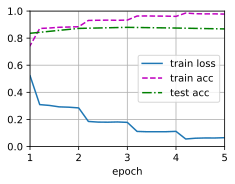

In [9]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

Below we use the trained model to predict the sentiment for two simple sentences.


In [10]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [11]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## Summary

* One-dimensional CNNs can process local features such as $n$-grams in text.
* Multi-input-channel one-dimensional cross-correlations are equivalent to single-input-channel two-dimensional cross-correlations.
* The max-over-time pooling allows different numbers of time steps at different channels.
* The textCNN model transforms individual token representations into downstream application outputs using one-dimensional convolutional layers and max-over-time pooling layers.


## Exercises

1. Tune hyperparameters and compare the two architectures for sentiment analysis in :numref:`sec_sentiment_rnn` and in this section, such as in classification accuracy and computational efficiency.
1. Can you further improve the classification accuracy of the model by using the methods introduced in the exercises of :numref:`sec_sentiment_rnn`?
1. Add positional encoding in the input representations. Does it improve the classification accuracy?


[Discussions](https://discuss.d2l.ai/t/1425)
